In [57]:
import itertools
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.linalg
import pandas as pd
import sklearn.linear_model
import sklearn.metrics
from tqdm import tqdm


In [58]:
sns.set_context("notebook")
sns.set_palette("deep")

In [59]:
df = pd.read_pickle('deception_df.pkl')


In [60]:
df.head()


,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id,politeness,negative_sentiment,neutral_sentiment,positive_sentiment,vader_score
0,"Hi Italy! Just opening up communication, and I...",True,True,germany,italy,87,0,Spring,1901,3,0,"italy,germany",12,4.252354,0.0,1.0,0.0,0.1511
1,"Well....that's a great question, and a lot of ...",True,True,italy,germany,132,1,Spring,1901,3,0,"italy,germany",12,3.552174,1.0,0.0,0.0,0.8225
2,"Well, if you want to attack France in the Medi...",True,False,germany,italy,138,2,Spring,1901,3,0,"italy,germany",12,3.407326,0.0,1.0,0.0,-0.3612
3,"Hello, I'm just asking about your move to Tyro...",True,True,germany,italy,207,3,Winter,1901,5,1,"italy,germany",12,4.187604,0.0,1.0,0.0,0.0000
4,Totally understandable - but did you notice th...,True,False,italy,germany,221,4,Winter,1901,4,-1,"italy,germany",12,3.583743,0.0,0.5,0.5,0.7783


In [61]:
df.loc[df['receiver_labels'] == 'NOANNOTATION', 'receiver_labels'] = None
df.dropna(axis=0, subset=['receiver_labels'], inplace=True)
df['receiver_labels'] = df['receiver_labels'].astype(bool)

In [62]:
df["years"] = df["years"].astype(int)
df["game_score"] = df["game_score"].astype(int)
df["game_score_delta"] = df["game_score_delta"].astype(int)

In [63]:
# Truth = True, lie = False
straightforward_mask = df['sender_labels'] & df['receiver_labels']
deceived_mask = ~df['sender_labels'] & df['receiver_labels']
cassandra_mask = df['sender_labels'] & ~df['receiver_labels']
caught_mask = ~df['sender_labels'] & ~df['receiver_labels']

straightforward =  sum(straightforward_mask) # Truths perceived as truths
deceived =  sum(deceived_mask) # Lies perceived as truths
cassandra =  sum(cassandra_mask) # Truths perceived as lies
caught = sum(caught_mask) # Lies perceived as lies

# tp = sum(tp_mask) # Lies perceived as lies
# fp = sum(fp_mask) # Truths perceived as lies
# tn = sum(tn_mask) # Truths perceived as truths
# fn = sum(fn_mask) # Lies perceived as truths

print("Straightforward: {}, Deceived: {}, Cassandra: {}, Caught: {}".format(straightforward, deceived, cassandra, caught))

Straightforward: 14314, Deceived: 691, Cassandra: 667, Caught: 111


In [68]:
def compute_propensity_scores(dataset, group_masks, confounder_cols):
    """Compute the propensity scores of a sample.
    
    Parameters
    ----------
    dataset : pd.DataFrame
        The dataset from which the two groups are drawn.
    group_masks : list of pd.Series
        A list of boolean masks identifying members of each group.
    confounder_cols : list of str
        The labels of the dataset columns corresponding to confounders.
        
    Returns
    -------
    group_data : pd.DataFrame
        The treatment and control groups.
    """
    groups = [dataset[group_mask].copy() for group_mask in group_masks]
    for i, group in enumerate(groups):
        group['treatment'] = i
    group_data = pd.concat(groups)
    X_train, y_train = group_data[confounder_cols], group_data['treatment']
    
    propensity_model = sklearn.linear_model.LogisticRegression().fit(X_train, y_train)
    group_data['propensity_scores'] = list(propensity_model.predict_proba(X_train))
    
    return group_data

In [69]:
def psm(dataset, group_masks, confounder_cols, max_caliper=0.2):
    """Perform propensity score caliper matching between the treatment and control groups.
    
    Parameters
    ----------
    dataset : pd.DataFrame
        The dataset from which the two groups are drawn.
    group_masks : list of pd.Series
        A list of boolean masks identifying members of each group.
    confounder_cols : list of str
        The labels of the dataset columns corresponding to confounders.
    max_caliper : float
        The maximum allowed difference between the propensity scores of the observations.
        
    Returns
    -------
    matches : list of tuples of ints
        A list of ordered pairs of index values for respectively the treatment and control groups.
    """
    
    group_data = compute_propensity_scores(dataset, group_masks, confounder_cols)
    
    matches = []
    
    groups = [group_data[group_data['treatment'] == i] for i in group_data['treatment'].unique()]
    
    indices = np.argsort([len(group) for group in groups])
    groups = sorted(groups, key=len)
    smallest_group, search_groups = groups[0], groups[1:]
    smallest_indices, search_indices = list(smallest_group.index), list(map(lambda group: list(group.index), search_groups))
    
    def caliper_valid(propensities):
        pair_propensity_differences = np.vstack(list(map(lambda pair: abs(pair[0] - pair[1]), itertools.combinations(propensities[:], 2))))
        return (pair_propensity_differences < max_caliper).all()
    
    test_p = np.array([[1, 2, 3], [6, 5, 4], [7, 8, 9]])
    caliper_valid(test_p)
    
    for smallest_index in tqdm(smallest_indices):
        possible_match_index_tuples = itertools.product([smallest_index], *search_indices)
        match = next((possible_match for possible_match in possible_match_index_tuples if caliper_valid(np.vstack(list(map(lambda match, group: group.loc[match, 'propensity_scores'], possible_match, groups))))), None)
        if match:
            matches.append(match)
            for group_idx, search_index in enumerate(match[1:]):
                search_indices[group_idx].remove(search_index)
            
    print("Matched {} treatment observations out of max {} (success rate {:.2%}).".format(len(matches), len(smallest_group), len(matches) / len(smallest_group)))
    
    reordered_matches = []
    for match in matches:
        reordered_matches.append([match[i] for i in indices])
        
    return reordered_matches

In [71]:
def psm(dataset, group_masks, confounder_cols, max_caliper=0.2):
    """Perform propensity score caliper matching between the treatment and control groups.
    
    Parameters
    ----------
    dataset : pd.DataFrame
        The dataset from which the two groups are drawn.
    group_masks : list of pd.Series
        A list of boolean masks identifying members of each group.
    confounder_cols : list of str
        The labels of the dataset columns corresponding to confounders.
    max_caliper : float
        The maximum allowed difference between the propensity scores of the observations.
        
    Returns
    -------
    matches : list of tuples of ints
        A list of ordered pairs of index values for respectively the treatment and control groups.
    """
    
    group_data = compute_propensity_scores(dataset, group_masks, confounder_cols)
    
    matches = []
    
    groups = [group_data[group_data['treatment'] == i] for i in group_data['treatment'].unique()]
    
    indices = np.argsort([len(group) for group in groups])
    groups = sorted(groups, key=len)
    smallest_group, search_groups = groups[0], groups[1:]
    smallest_indices, search_indices = list(smallest_group.index), list(map(lambda group: list(group.index), search_groups))
    def caliper_valid(propensities):
        pair_propensity_differences = np.vstack(list(map(lambda pair: abs(pair[0] - pair[1]), itertools.combinations(propensities[:], 2))))
        return (pair_propensity_differences < max_caliper).all()
    
    test_p = np.array([[1, 2, 3], [6, 5, 4], [7, 8, 9]])
    caliper_valid(test_p)
    
    for smallest_index in tqdm(smallest_indices):
        possible_match_index_tuples = itertools.product([smallest_index], *search_indices)
        match = next((possible_match for possible_match in possible_match_index_tuples if caliper_valid(np.vstack(list(map(lambda match, group: group.loc[match, 'propensity_scores'], possible_match, groups))))), None)
        if match:
            matches.append(match)
            for group_idx, search_index in enumerate(match[1:]):
                search_indices[group_idx].remove(search_index)
            
    print("Matched {} treatment observations out of max {} (success rate {:.2%}).".format(len(matches), len(smallest_group), len(matches) / len(smallest_group)))
    
    reordered_matches = []
    for match in matches:
        reordered_matches.append([match[i] for i in indices])
        
    return reordered_matches

In [72]:
effect_cols = ['politeness', 'negative_sentiment', 'neutral_sentiment', 'positive_sentiment', 'vader_score']
confounder_cols = ['game_score', 'game_score_delta', 'years']

In [73]:
def plot_distribution(df, target, hue, title=""):
    """ 
    Plots distributions (using a histogram and a KDE plot) for the reputation and ratings variable, using arxiv as a hue
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), dpi=80)
    # Reputation (don't plot KDE in same subplot as hist as it's harder to discern)
    sns.histplot(df, ax=ax[0], x=target, hue=hue, multiple="layer", stat="density", common_norm=False)
    sns.kdeplot(data=df, ax=ax[1], x=target, hue=hue, fill=True, common_norm=False)

    sns.despine(fig)
    fig.suptitle(title, fontsize=14)
    fig.tight_layout()
    plt.show()

In [74]:
def check_balance(dataset, matches, confounder_cols):
    """Visualize the confounder distributions across groups to check balance.
    
    Parameters
    ----------
    dataset : pd.DataFrame
        The dataset from which the two groups are drawn.
    matches : list of (int, int)
        A list of ordered pairs of index values for respectively the treatment and control groups.
    confounder_cols : list of str
        The labels of the dataset columns corresponding to confounders.
    """
    groups = []
    for group_idx in range(len(matches[0])):
        group_indices = [match[group_idx] for match in matches]
        group = dataset.loc[group_indices]
        group['group'] = group_idx
        groups.append(group)
        
    matched = pd.concat(groups)
    
    for confounder_col in confounder_cols:
        title = "Balance test for confounder {}".format(confounder_col)
        
        plot_distribution(matched, target=confounder_col, hue="group", title=title)

In [75]:
treatment_mask_q1 = ~df['sender_labels']
control_mask_q1 = df['sender_labels']

matches_q1 = psm(df, [treatment_mask_q1, control_mask_q1], confounder_cols, max_caliper=0.001)

100%|██████████| 802/802 [00:27<00:00, 29.04it/s] 

Matched 801 treatment observations out of max 802 (success rate 99.88%).


In [76]:
flatten = lambda t: [item for sublist in t for item in sublist]
q1_match_df = df.loc[flatten(matches_q1)]

<ipython-input-77-dc8fa0343953>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  ax = sns.barplot(ax=ax, data=q1_match_df, x="sender_labels", y="politeness",


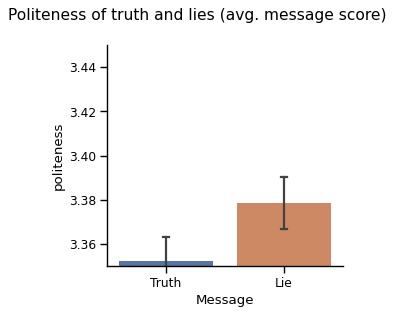

In [77]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=80)
ax = sns.barplot(ax=ax, data=q1_match_df, x="sender_labels", y="politeness", 
                 ci=68, n_boot=2000, order=[True, False], capsize=0.05, errwidth=2)
ax.set_ylim([3.35, 3.45])
ax.set_xlabel("Message")
ax.set_xticklabels(["Truth", "Lie"])
sns.despine(fig)
fig.suptitle("Politeness of truth and lies (avg. message score)", fontsize=14)
fig.tight_layout()
plt.show()

<ipython-input-78-2077e562bfb4>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  ax = sns.barplot(ax=ax, data=q1_match_df, x="sender_labels", y="positive_sentiment",


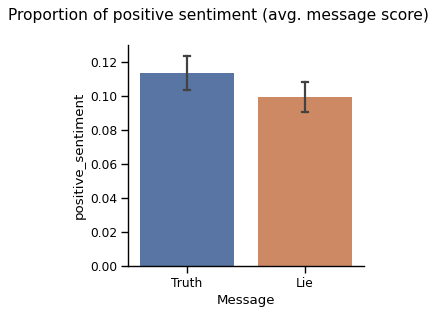

In [78]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=80)
ax = sns.barplot(ax=ax, data=q1_match_df, x="sender_labels", y="positive_sentiment", 
                 ci=68, n_boot=2000, order=[True, False], capsize=0.05, errwidth=2)
ax.set_xlabel("Message")
ax.set_xticklabels(["Truth", "Lie"])
sns.despine(fig)
fig.suptitle("Proportion of positive sentiment (avg. message score)", fontsize=14)
fig.tight_layout()
plt.show()

<ipython-input-79-593d30819d0b>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  ax = sns.barplot(ax=ax, data=q1_match_df, x="sender_labels", y="vader_score",


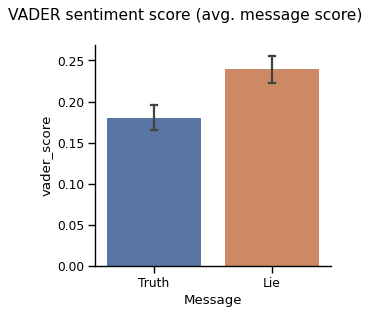

In [79]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=80)
ax = sns.barplot(ax=ax, data=q1_match_df, x="sender_labels", y="vader_score", 
                 ci=68, n_boot=2000, order=[True, False], capsize=0.05, errwidth=2)
ax.set_xlabel("Message")
ax.set_xticklabels(["Truth", "Lie"])
sns.despine(fig)
fig.suptitle("VADER sentiment score (avg. message score)", fontsize=14)
fig.tight_layout()
plt.show()

In [80]:
treatment_mask_q2 = ~df['sender_labels']
control_mask_q2 = ~df['receiver_labels']

matches_q2 = psm(df, [treatment_mask_q2, control_mask_q2], confounder_cols, max_caliper=0.001)

selected_lie_indices = [m for (m, n) in matches_q2]
selected_lies = df.loc[selected_lie_indices]
selected_perceived_lie_indices = [n for (m, n) in matches_q2]
selected_perceived_lies = df.loc[selected_perceived_lie_indices]

100%|██████████| 778/778 [00:06<00:00, 117.40it/s]

Matched 602 treatment observations out of max 778 (success rate 77.38%).


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

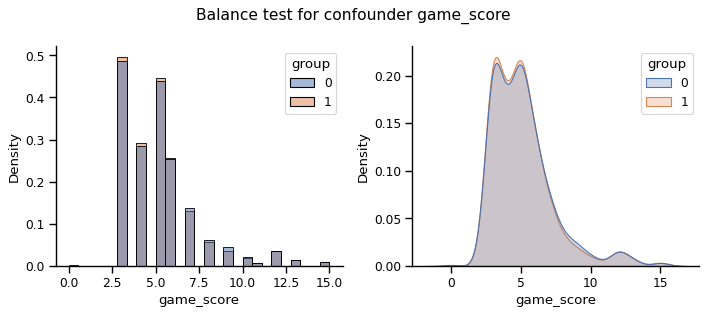

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

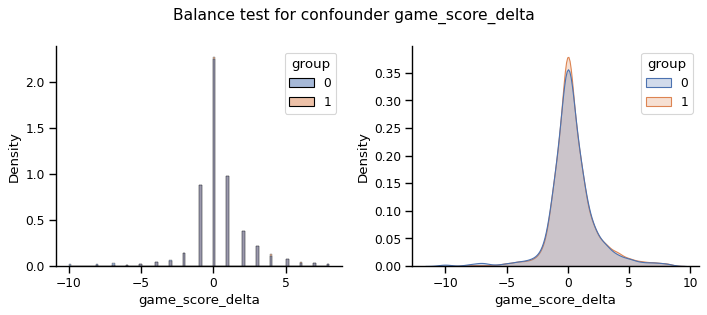

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

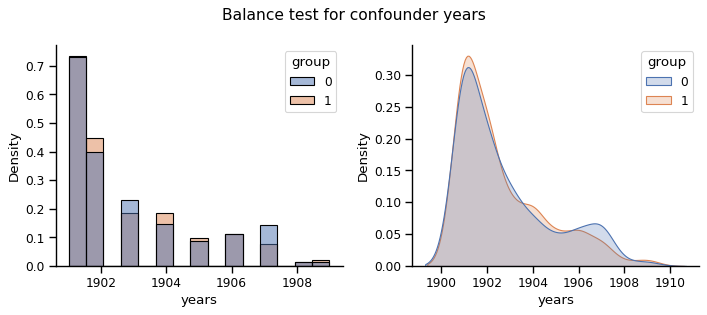

In [81]:
check_balance(df, matches_q2, confounder_cols)

In [82]:
selected_lies['Lie Category'] = "Actual Lie"
selected_perceived_lies["Lie Category"] = "Perceived Lie"
q2_match_df = pd.concat([selected_lies, selected_perceived_lies])

In [83]:
selected_lies['Lie Category'] = "Actual Lie"
selected_perceived_lies["Lie Category"] = "Perceived Lie"
q2_match_df = pd.concat([selected_lies, selected_perceived_lies])

<ipython-input-84-95b1fb216c96>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  ax = sns.barplot(ax=ax, data=q2_match_df, x="Lie Category", y="positive_sentiment",


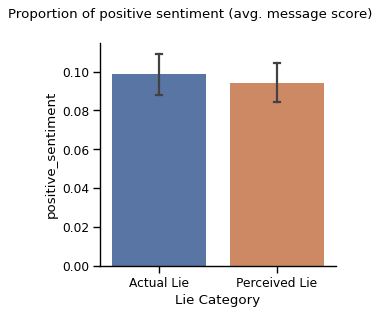

In [84]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=80)
ax = sns.barplot(ax=ax, data=q2_match_df, x="Lie Category", y="positive_sentiment", 
                 ci=68, n_boot=2000, order=["Actual Lie", "Perceived Lie"], capsize=0.05, errwidth=2)
sns.despine(fig)
fig.suptitle("Proportion of positive sentiment (avg. message score)", fontsize=12)
fig.tight_layout()
plt.show()

<ipython-input-85-c203fd3544c9>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  ax = sns.barplot(ax=ax, data=q2_match_df, x="Lie Category", y="neutral_sentiment",


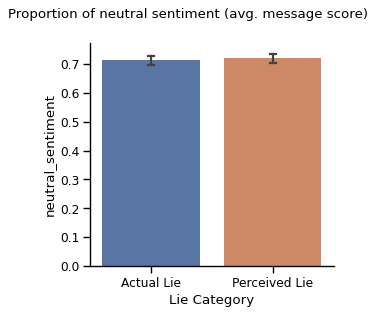

In [85]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=80)
ax = sns.barplot(ax=ax, data=q2_match_df, x="Lie Category", y="neutral_sentiment", 
                 ci=68, n_boot=2000, order=["Actual Lie", "Perceived Lie"], capsize=0.05, errwidth=2)
sns.despine(fig)
fig.suptitle("Proportion of neutral sentiment (avg. message score)", fontsize=12)
fig.tight_layout()
plt.show()

<ipython-input-86-ba646a34752b>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  ax = sns.barplot(ax=ax, data=q2_match_df, x="Lie Category", y="negative_sentiment",


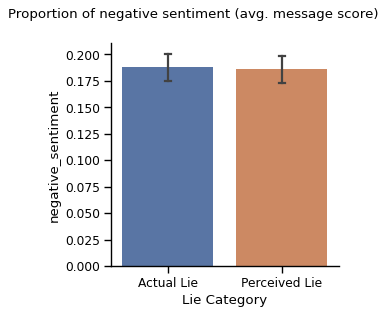

In [86]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=80)
ax = sns.barplot(ax=ax, data=q2_match_df, x="Lie Category", y="negative_sentiment", 
                 ci=68, n_boot=2000, order=["Actual Lie", "Perceived Lie"], capsize=0.05, errwidth=2)
sns.despine(fig)
fig.suptitle("Proportion of negative sentiment (avg. message score)", fontsize=12)
fig.tight_layout()
plt.show()

In [87]:
def match_4(row, straightforward_data, cassandra_data, deceived_data):
    match = {
            'caught': row,
            'straightforward':None,
            'deceived': None,
            'cassandra': None,
            }
    
    nb_match = 0
    
    for distance_game_score in range(3):
        
        for distance_delta in range(3):
            
            for distance_year in range(2):
                
                if match['straightforward'] is None:
                    data = straightforward_data.loc[
                        straightforward_data.game_score.isin(list(range(row.game_score-distance_game_score,row.game_score+distance_game_score))) & 
                        straightforward_data.game_score_delta.isin(list(range(row.game_score_delta-distance_delta,row.game_score+distance_delta))) & 
                        straightforward_data.years.isin(list(range(row.years-distance_year,row.years+distance_year)))]
                    
                    if not data.empty:
                        nb_match += 1
                        match['straightforward'] = data.iloc[0,:]
                        # remove message from data
                        straightforward_data.drop(int(match['straightforward'].name), inplace=True)
                        
                        
                if match['deceived'] is None:
                    data = deceived_data.loc[
                        deceived_data.game_score.isin(list(range(row.game_score-distance_game_score,row.game_score+distance_game_score))) & 
                        deceived_data.game_score_delta.isin(list(range(row.game_score_delta-distance_delta,row.game_score+distance_delta))) & 
                        deceived_data.years.isin(list(range(row.years-distance_year,row.years+distance_year)))]
                    
                    if not data.empty:
                        nb_match += 1
                        match['deceived'] = data.iloc[0,:]
                        deceived_data.drop(int(match['deceived'].name), inplace=True)
                        
                        
                if match['cassandra'] is None:
                    data = cassandra_data.loc[
                        cassandra_data.game_score.isin(list(range(row.game_score-distance_game_score,row.game_score+distance_game_score))) &             
                        cassandra_data.game_score_delta.isin(list(range(row.game_score_delta-distance_delta,row.game_score+distance_delta))) &                
                        cassandra_data.years.isin(list(range(row.years-distance_year,row.years+distance_year)))]
                    
                    if not data.empty:
                        nb_match += 1
                        match['cassandra'] = data.iloc[0,:]
                        cassandra_data.drop(int(match['cassandra'].name), inplace=True)
                        
                        
                if nb_match == 3:
                    return match

In [88]:
def heuristic_matching(df):
    straightforward_data = df.loc[straightforward_mask].copy()
    deceived_data = df.loc[deceived_mask].copy() # Lies perceived as truths
    cassandra_data = df.loc[cassandra_mask].copy() # Truths perceived as lies
    caught_data = df.loc[caught_mask].copy() # Lies perceived as lies
    
    matches = []
    
                
    for i, row in tqdm(caught_data.iterrows()):
        match = match_4(row, straightforward_data, cassandra_data, deceived_data)
        if match is not None:
            matches.append(match)
            
    print(f"Percentage matched: {len(matches) /len(caught_data) * 100: .2f}%")
        
    matched_straightforward = pd.concat([pd.DataFrame(match["straightforward"]) for match in matches], axis=1).T
    matched_straightforward['group'] = "Straightforward"
    
    matched_deceived = pd.concat([pd.DataFrame(match["deceived"]) for match in matches], axis=1).T
    matched_deceived['group'] = "Deceived"
    
    matched_cassandra = pd.concat([pd.DataFrame(match["cassandra"]) for match in matches], axis=1).T
    matched_cassandra['group'] = "Cassandra"
    
    matched_caught = pd.concat([pd.DataFrame(match["caught"]) for match in matches], axis=1).T
    matched_caught['group'] = "Caught"

    concat = pd.concat([matched_straightforward, matched_deceived, matched_cassandra, matched_caught], axis=0).reset_index()
    
    for x in df.columns:
        concat[x] = concat[x].astype(df[x].dtypes.name)
        
    return concat

In [89]:
q3_match_df = heuristic_matching(df)


111it [00:02, 38.75it/s]


Percentage matched:  99.10%


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

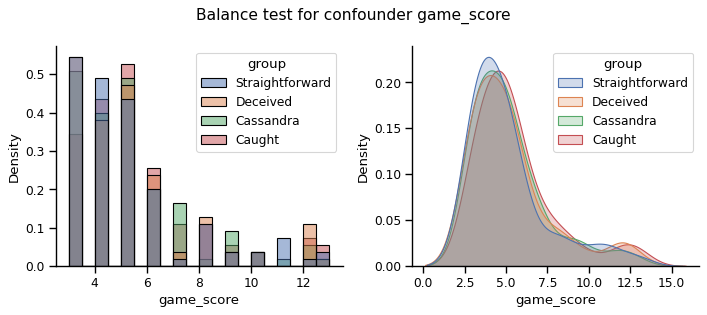

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

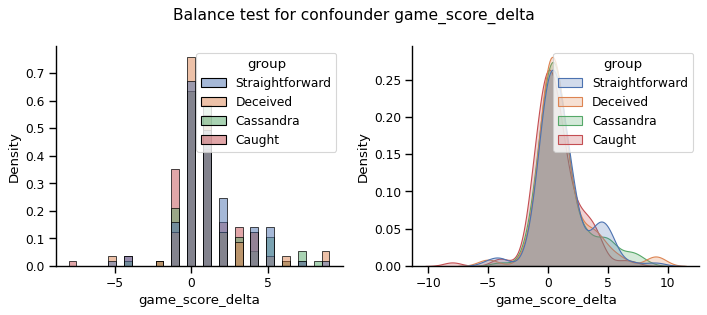

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

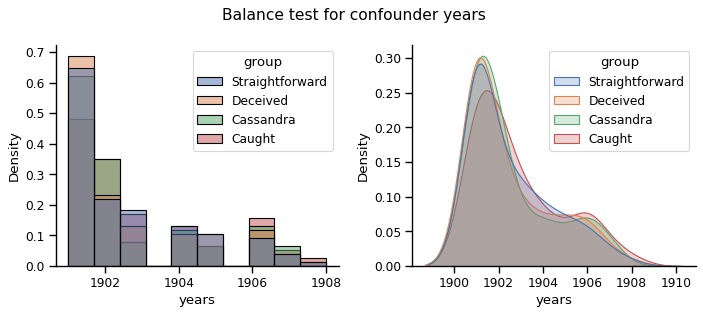

In [90]:
for confounder_col in confounder_cols:
    title = "Balance test for confounder {}".format(confounder_col)

    plot_distribution(q3_match_df, target=confounder_col, hue="group", title=title)

<ipython-input-91-e8dce157dfa3>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  ax = sns.barplot(ax=ax, data=q3_match_df, x="group", y="politeness",


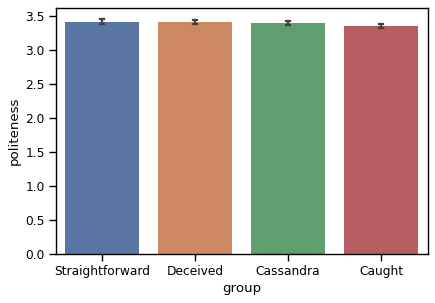

In [91]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=80)
ax = sns.barplot(ax=ax, data=q3_match_df, x="group", y="politeness", 
                 ci=68, n_boot=2000, capsize=0.05, errwidth=2)

<ipython-input-92-a0c7ee08b0b6>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  ax = sns.barplot(ax=ax, data=q3_match_df, x="group", y="positive_sentiment",


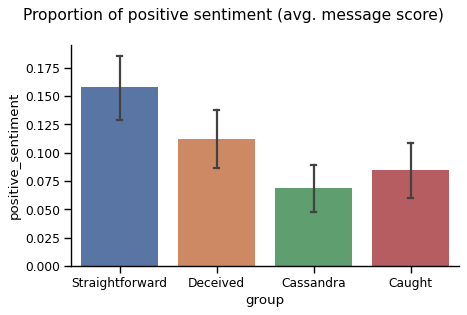

In [92]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=80)
ax = sns.barplot(ax=ax, data=q3_match_df, x="group", y="positive_sentiment", 
                 ci=68, n_boot=2000, capsize=0.05, errwidth=2)
sns.despine(fig)
fig.suptitle("Proportion of positive sentiment (avg. message score)", fontsize=14)
fig.tight_layout()
plt.show()

<ipython-input-93-d49e81ceaff0>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  ax = sns.barplot(ax=ax, data=q3_match_df, x="group", y="neutral_sentiment",


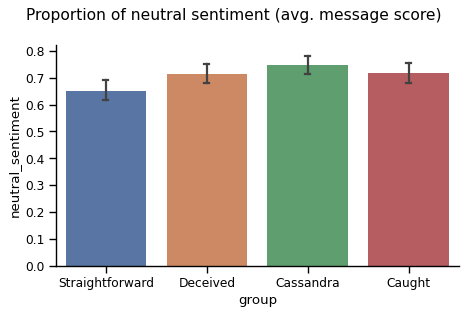

In [93]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=80)
ax = sns.barplot(ax=ax, data=q3_match_df, x="group", y="neutral_sentiment", 
                 ci=68, n_boot=2000, capsize=0.05, errwidth=2)
sns.despine(fig)
fig.suptitle("Proportion of neutral sentiment (avg. message score)", fontsize=14)
fig.tight_layout()
plt.show()

<ipython-input-94-f005b536d490>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  ax = sns.barplot(ax=ax, data=q3_match_df, x="group", y="negative_sentiment",


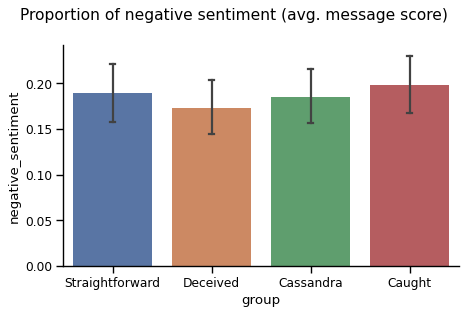

In [94]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=80)
ax = sns.barplot(ax=ax, data=q3_match_df, x="group", y="negative_sentiment", 
                 ci=68, n_boot=2000, capsize=0.05, errwidth=2)
sns.despine(fig)
fig.suptitle("Proportion of negative sentiment (avg. message score)", fontsize=14)
fig.tight_layout()
plt.show()

<ipython-input-95-57a9c1546246>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  ax = sns.barplot(ax=ax, data=q3_match_df, x="group", y="vader_score",


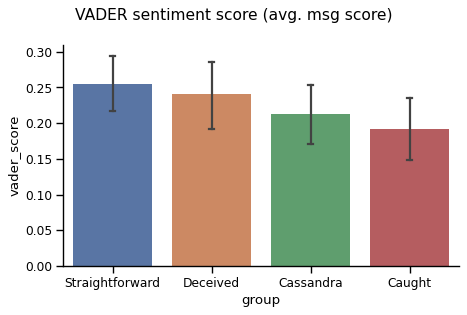

In [95]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=80)
ax = sns.barplot(ax=ax, data=q3_match_df, x="group", y="vader_score", 
                 ci=68, n_boot=2000, capsize=0.05, errwidth=2)
sns.despine(fig)
fig.suptitle("VADER sentiment score (avg. msg score)", fontsize=14)
fig.tight_layout()
plt.show()